In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import os
import sys
import numpy as np
import pandas as pd

sys.path.insert(1, '/scr/gmachi/prospection/K2/src')
from utils import deserialize, serialize, deserialize_model

In [30]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from sklearn.preprocessing import MinMaxScaler

## setup

In [32]:
# feats_dict = deserialize("/scr/biggest/gmachi/datasets/celldive_lung/raw_sample.obj")

In [33]:
# print(list(feats_dict.keys())[0])
# print(len(feats_dict.keys()))

## K-means on marker expression alone
- we are curious how expression alone clusters. Let's sample the same cells used for layer I in prospector heads

In [34]:
# from sklearn.cluster import KMeans

# X = np.array(list(feats_dict.values()))
# print(X.shape)
# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto").fit(X)


In [35]:
# serialize(kmeans, "/scr/biggest/gmachi/datasets/celldive_lung/kmeans_on_raw.obj")

## Now label all cells in all graphs by this k-means model
do this for all data + class-1 on salient dataset

In [36]:
# import networkx as nx

In [37]:
# G_dir1 = "/scr/biggest/gmachi/datasets/celldive_lung/for_ml/for_prospect"
# save_dir1 = "/scr/biggest/gmachi/datasets/celldive_lung/clustered_only"

In [38]:
# for i,G in enumerate(os.listdir(G_dir1)):
#     G_file = G.split(".")[0] + "_with_clusters.obj"
#     G_path = os.path.join(G_dir1, G)
#     G = deserialize(G_path)
    
#     G_new = G.copy()
#     raw_dict = nx.get_node_attributes(G_new, "raw")
#     node_ids = list(raw_dict.keys())
#     G_feats = np.array(list(raw_dict.values()))
#     G_clusters = kmeans.predict(G_feats)
#     cluster_dict = dict(zip(node_ids, G_clusters))
    
#     nx.set_node_attributes(G_new, cluster_dict, "exp_cluster")
#     save_path = os.path.join(save_dir1, G_file)
#     serialize(G_new, save_path)
    
#     if i % 20 == 0:
#         print("completed", i)

In [39]:
# G_dir2 = "/scr/biggest/gmachi/datasets/celldive_lung/prospected/k9r3fc_concept_overlay"
# save_dir2 = "/scr/biggest/gmachi/datasets/celldive_lung/prospected/k9r3fc_concept_cluster"

In [40]:
# for i,G in enumerate(os.listdir(G_dir2)):
#     G_file = G.split(".")[0] + "_with_clusters.obj"
#     G_path = os.path.join(G_dir2, G)
#     G = deserialsize(G_path)
    
#     G_new = G.copy()
#     raw_dict = nx.get_node_attributes(G_new, "raw")
#     node_ids = list(raw_dict.keys())
#     G_feats = np.array(list(raw_dict.values()))
#     G_clusters = kmeans.predict(G_feats)
#     cluster_dict = dict(zip(node_ids, G_clusters))
    
#     nx.set_node_attributes(G_new, cluster_dict, "exp_cluster")
#     save_path = os.path.join(save_dir2, G_file)
#     serialize(G_new, save_path)
    
#     if i % 20 == 0:
#         print("completed", i)

we use the above graphs for spatial analysis. we use dataframes as our ridgeline plotting source

## now we take a look at clusters' marker distributions
- we use riddgeline plots as we do for concepts

In [41]:
import pandas as pd
dfGs_all = pd.read_csv("/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/top_model_results/dfGs_all.csv")

In [42]:
dfGs_all.columns

Index(['Unnamed: 0', 'node', 'cell_id', 'cell_type', 'concept', 'salient',
       'emb', 'raw', 'salbin', 'class_member'],
      dtype='object')

In [43]:
def parse_df_list(row):
    row = row.split(" ")
    row = [r.strip() for r in row]
    row = [r.rstrip("]") for r in row]
    row = [r.lstrip("[]") for r in row]
    row = [float(r) for r in row if r not in ["[", "", "]"]]     
    return row

we first assign cluster IDs to all cells

In [44]:
kmeans = deserialize("/scr/biggest/gmachi/datasets/celldive_lung/kmeans_on_raw.obj")

In [45]:
X = dfGs_all.loc[:, "raw"]
X = X.apply(lambda x: parse_df_list(x))
X = np.vstack(list(X.values))
dfGs_all["exp_cluster"] = kmeans.predict(X)

In [46]:
dfGs_all.columns

Index(['Unnamed: 0', 'node', 'cell_id', 'cell_type', 'concept', 'salient',
       'emb', 'raw', 'salbin', 'class_member', 'exp_cluster'],
      dtype='object')

In [47]:
G_ex = deserialize("/scr/biggest/gmachi/datasets/celldive_lung/for_ml/for_prospect/S3.obj")
prot_feats = list(G_ex.nodes[0]["biomarker_expression"].keys())
morph_feats = ['AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER']
all_feats = prot_feats + morph_feats
print(all_feats)

['AKT', 'AMPHIREGULIN', 'BETA_CATENIN', 'BETA_TUBULIN', 'CA9', 'CK5', 'CK7', 'CMET', 'CYCLIN_B', 'ECAD', 'EGFR', 'EGFR_PY1068', 'ERK', 'ERK1_2_PT202_PY204', 'HER2', 'IGF1R', 'NAKATPASE', 'P21', 'P4EBP1', 'PANKERATIN', 'PGSK3BETA', 'PHISTONEH3', 'PHOSPHOTYROSINE', 'PTEN', 'RRM1', 'S6', 'STAT3', 'STAT3_PY705', 'VGFR2', 'AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER']


In [48]:
feat2idx_dict = {feat: i for i,feat in enumerate(all_feats)}

## Do some quick differences between some features

In [62]:
X_nonsal = dfGs_all[dfGs_all["salbin"] == "non-salient"]["raw"].apply(lambda x: parse_df_list(x))
X_nonsal = np.vstack(list(X_nonsal.values))
X_nonsal

array([[ 11.06986137,   9.43431884,   6.23159847, ...,  19.        ,
          8.298     ,  53.        ],
       [ 10.86945364,  10.11149771,   0.        , ...,  26.861     ,
         17.553     ,  88.        ],
       [ 11.37024529,  10.14242957,   0.        , ...,  15.787     ,
          7.649     ,  44.        ],
       ...,
       [  8.96297771,  10.4202079 ,   8.45550555, ...,  55.981     ,
         31.846     , 196.        ],
       [  9.11771859,  10.32156259,   8.38763752, ...,  33.004     ,
         21.765     , 117.        ],
       [  8.88231951,  10.3481774 ,   8.29331306, ...,  67.692     ,
         34.406     , 227.        ]])

In [63]:
X_sal = dfGs_all[dfGs_all["salbin"] == "salient"]["raw"].apply(lambda x: parse_df_list(x))
X_sal = np.vstack(list(X_sal.values))
X_sal

In [82]:
diffs = []
feats_focus = all_feats#["PANKERATIN", "CK5", "PHOSPHOTYROSINE", "P4EBP1", "CK7", "P21"]
for feat in feats_focus:
    diff = np.std(X_sal[:, feat2idx_dict[feat]]) - np.std(X_nonsal[:, feat2idx_dict[feat]])
    diffs.append(diff)

<BarContainer object of 34 artists>

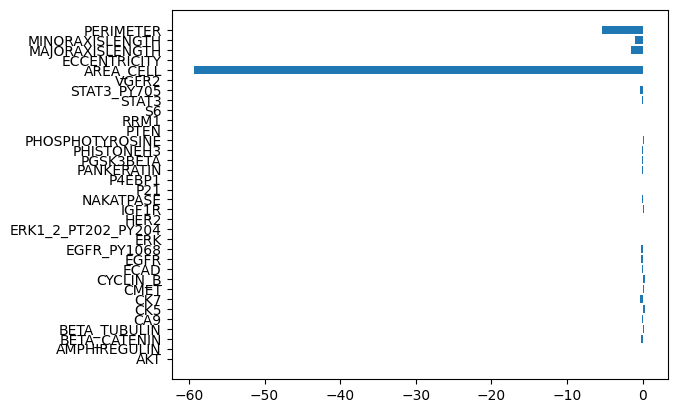

: 

In [83]:
plt.figure()
plt.barh(feats_focus, diffs)

## Now we do ridgelines!

In [13]:
CMAP2 = "Pastel2"
joint_cmap = colors.ListedColormap(cm.tab20.colors + cm.Pastel2.colors, name='tab40')
joint_cmap.set_bad(color='lightgray') #used to be white

In [14]:
def filter_data(key, value, df):
    subset = df[df[key] == value]
    return subset

def filter_data_2conds(key_a, value_a, key_b, value_b, df):
    subset = df[(df[key_a] == value_a) & (df[key_b] == value_b)]
    return subset

def plot_ridgeline(key, value, df, feat_names, feat2idx_dict=None, cond_count=1):
    if key == "cluster":
        search_key = "exp_cluster"
    else:
        search_key = key
    
    if len(feat_names) < 34 and feat2idx_dict is not None:
        idxs = [feat2idx_dict[feat] for feat in feat_names]
        
    X_all = df.loc[:, "raw"]
    X_all = X_all.apply(lambda x: parse_df_list(x))
    X_all = np.vstack(list(X_all.values))
    scaler = MinMaxScaler()
    scaler.fit(X_all)
    
    if cond_count == 1:
        subset = filter_data(search_key, value, df)
    elif cond_count == 2:
        subset = filter_data_2conds(search_key, value, "salbin", "salient", df)
    else:
        print("Error: only 1 or 2 conditions are supported.")
        exit()
        
    X = subset.loc[:, "raw"]
    X = X.apply(lambda x: parse_df_list(x))
    X = np.vstack(list(X.values))
    X = scaler.transform(X)
    p = X.shape[1]
    
    plt.figure()
    if len(feat_names) < 34 and feat2idx_dict is not None:
        print("Note: only using a subset of features as requested...")
        X = X[:, idxs]
        p = X.shape[1]
        fig, ax = plt.subplots(figsize=(2, 4))
        w = 1.5
    else: 
        fig, ax = plt.subplots(figsize=(3, 12))
        w = 1
    
    ax.yaxis.grid(True, linestyle='-')        
    
    parts = ax.violinplot(X, positions=np.arange(p), widths=w, vert=False, showmeans=True, showmedians=False, showextrema=False, side="high")
    
    if key == "concept":
        c = joint_cmap(value)
    else:
        c = "brown"
        
    for pc in parts['bodies']:
        pc.set_facecolor(c)
        # pc.set_edgecolor('black')
        pc.set_alpha(0.8)
    parts['cmeans'].set_colors("k")
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(key.title() + " " + str(value))
    #'Rescaled marker\ndistributions for ' +
    ax.set_yticks(np.arange(p), feat_names, rotation=0)
    ax.set_xlim(-0.05, 1.05)
    plt.show()
    
    return

In [15]:
# feat_subset = ['CK7', 'PANKERATIN', 'PHISTONEH3', 'AREA_CELL']
feat_subset = ['BETA_TUBULIN','CK5','CK7','P21','PANKERATIN','PHISTONEH3','AREA_CELL','MAJORAXISLENGTH']

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

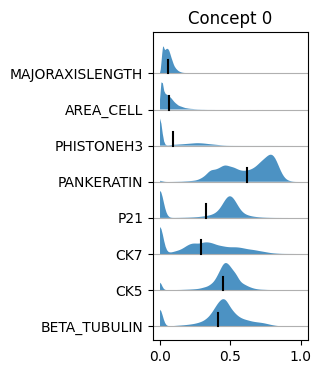

In [16]:
# plot_ridgeline("concept", 0, dfGs_all, all_feats)
plot_ridgeline("concept", 0, dfGs_all, feat_subset, feat2idx_dict)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

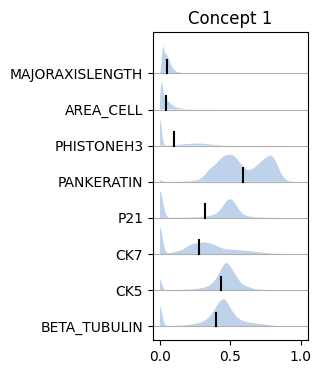

In [58]:
# plot_ridgeline("concept", 1, dfGs_all, all_feats)
plot_ridgeline("concept", 1, dfGs_all, feat_subset, feat2idx_dict)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

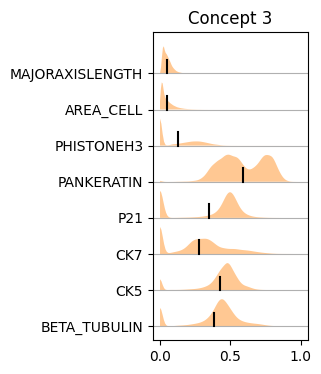

In [59]:
# plot_ridgeline("concept", 3, dfGs_all, all_feats)
plot_ridgeline("concept", 3, dfGs_all, feat_subset, feat2idx_dict)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

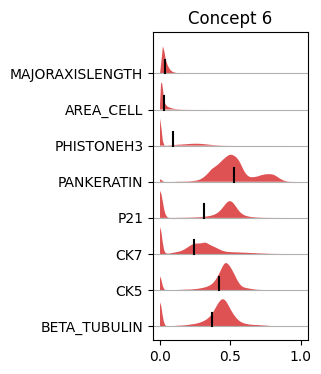

In [60]:
# plot_ridgeline("concept", 6, dfGs_all, all_feats)
plot_ridgeline("concept", 6, dfGs_all, feat_subset, feat2idx_dict)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

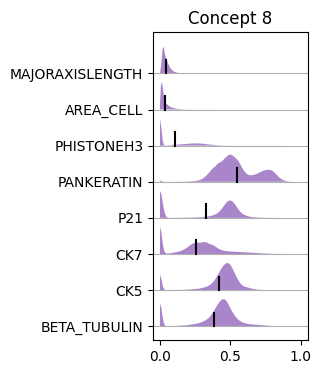

In [61]:
# plot_ridgeline("concept", 8, dfGs_all, all_feats)
plot_ridgeline("concept", 8, dfGs_all, feat_subset, feat2idx_dict)

other concepts

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

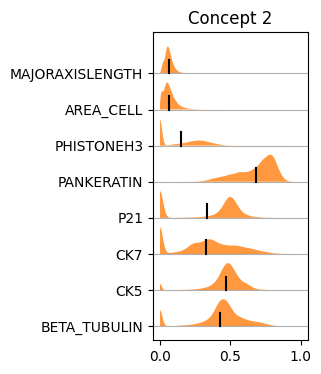

In [62]:
# plot_ridgeline("concept", 2, dfGs_all, all_feats)
plot_ridgeline("concept", 2, dfGs_all, feat_subset, feat2idx_dict)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

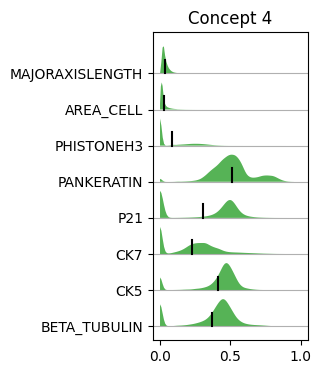

In [63]:
# plot_ridgeline("concept", 4, dfGs_all, all_feats)
plot_ridgeline("concept", 4, dfGs_all, feat_subset, feat2idx_dict)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

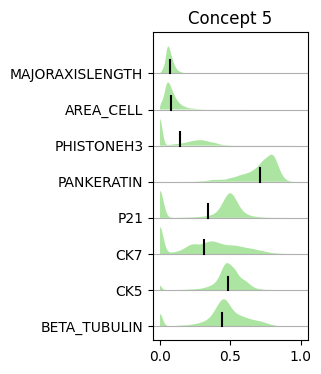

In [64]:
# plot_ridgeline("concept", 5, dfGs_all, all_feats)
plot_ridgeline("concept", 5, dfGs_all, feat_subset, feat2idx_dict)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

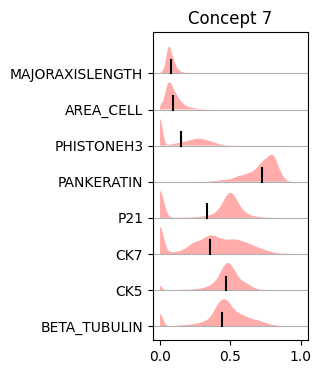

In [65]:
# plot_ridgeline("concept", 7, dfGs_all, all_feats)
plot_ridgeline("concept", 7, dfGs_all, feat_subset, feat2idx_dict)

## let's also do the clusters

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

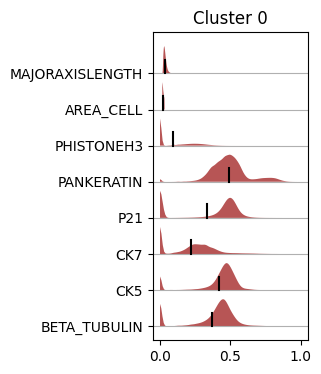

In [66]:
# plot_ridgeline("cluster", 0, dfGs_all, all_feats)
plot_ridgeline("cluster", 0, dfGs_all, feat_subset, feat2idx_dict)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

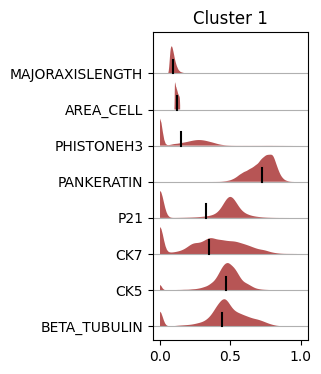

In [67]:
# plot_ridgeline("cluster", 1, dfGs_all, all_feats)
plot_ridgeline("cluster", 1, dfGs_all, feat_subset, feat2idx_dict)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

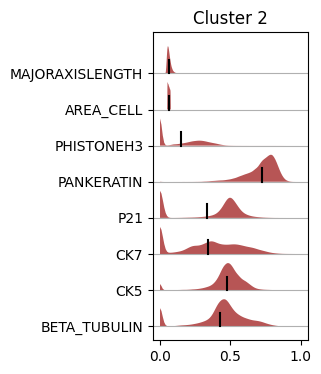

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

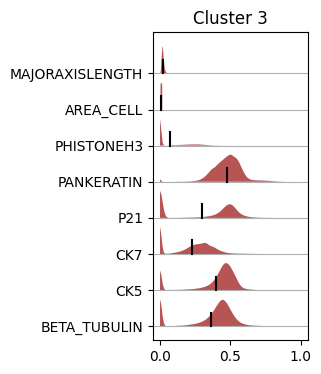

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

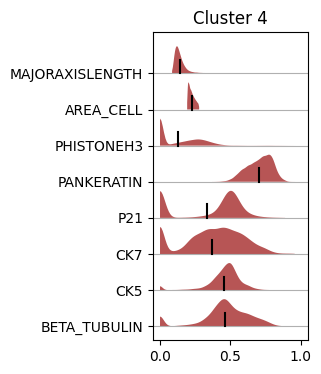

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

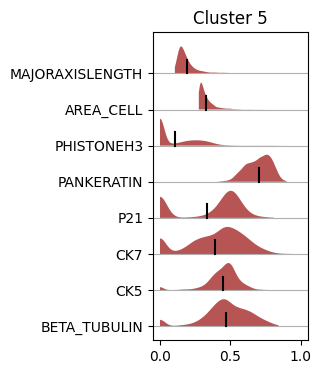

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

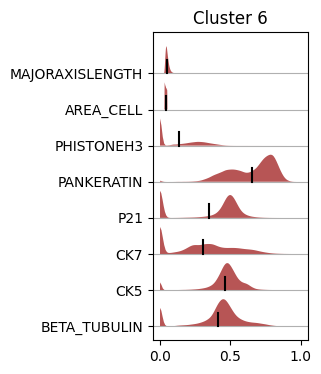

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

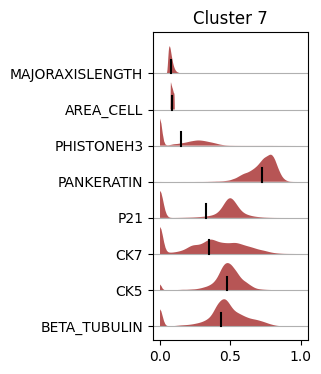

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

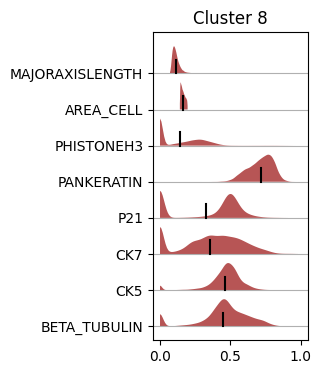

In [68]:
for i in range(2,9):
    plot_ridgeline("cluster", i, dfGs_all, feat_subset, feat2idx_dict)
    # plot_ridgeline("cluster", i, dfGs_all, all_feats)

## Now lets get distances from clusters and concepts

In [17]:
from scipy import stats
from scipy.spatial import distance
import ipdb

In [18]:
def diff_exp(X0, X1):
    mu0 = X0.mean(axis=0)    
    mu1 = X1.mean(axis=0)
    fc = np.log2(mu1 / mu0)
    pval = stats.ttest_ind(X1, X0)[1]
    pval_adj = pval * len(pval)
    pval_sig = pval_adj < 0.01
    res = [(i, fc[i], np.abs(fc[i]), pval_sig[i]) for i in range(len(fc)) if pval_sig[i] == True]
    res.sort(key=lambda x: x[2], reverse=True)
    return res[0]

def cos_dist(X0, X1):
    mu0 = X0.mean(axis=0)    
    mu1 = X1.mean(axis=0)
    return distance.cosine(mu0, mu1)
    
def compute_differences(key0, val0, key1, val1, df, mode="diff_exp"):
    if key0 == "cluster":
        search_key0 = "exp_cluster"
    else:
        search_key0 = key0
    if key1 == "cluster":
        search_key1 = "exp_cluster"
    else:
        search_key1 = key1
    
    subset0 = filter_data(search_key0, val0, df)
    subset1 = filter_data(search_key1, val1, df)
    
    X0 = subset0.loc[:, "raw"]
    X0 = X0.apply(lambda x: parse_df_list(x))
    X0 = np.vstack(list(X0.values))
    
    X1 = subset1.loc[:, "raw"]
    X1 = X1.apply(lambda x: parse_df_list(x))
    X1 = np.vstack(list(X1.values))
    
    if mode == "diff_exp":
        res = diff_exp(X0, X1)
    elif mode == "cos_dist":
        res = cos_dist(X0, X1)
    return res
    

def difference_runner(df, mode="diff_exp"):
    res_dict = {}
    for key0 in ["concept", "cluster"]:
        for val0 in range(9):
            for key1 in ["concept", "cluster"]:
                for val1 in range(9):
                    if key0 == key1 and val0 == val1:
                        continue
                    if (key0, val0, key1, val1) in res_dict.keys():
                        continue
                    if (key1, val1, key0, val0) in res_dict.keys():
                        continue
                    else:
                        print(key0, val0, key1, val1)
                        res = compute_differences(key0, val0, key1, val1, df, mode=mode)
                        res_dict[(key0, val0, key1, val1)] = res
    return res_dict
    

In [19]:
# res_dict_diffexp = difference_runner(dfGs_all, mode="diff_exp")

In [20]:
res_save_path = "/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/top_model_results/res_dict_de.obj"
# serialize(res_dict_diffexp, res_save_path)

In [21]:
res_dict_diffexp  = deserialize(res_save_path)

In [22]:
list(res_dict_diffexp.values())[0]

(29, -0.41664981772163556, 0.41664981772163556, True)

 now do cosine distances

In [23]:
# res_dict_cosine = difference_runner(dfGs_all, mode="cos_dist")

In [24]:
res_save_path = "/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/top_model_results/res_dict_cd.obj"
# serialize(res_dict_cosine, res_save_path)

In [25]:
res_dict_cosine  = deserialize(res_save_path)

In [8]:
comparisons = []
for el in ["concept", "cluster"]:
    for i in range(9):
        comparisons.append(el + " " + str(i))

In [41]:
N = len(comparisons)

In [28]:
res_arr = np.zeros((N,N))
print(res_arr.shape)
for i in range(N):
    for j in range(N):
        key0, val0 = comparisons[i].split(" ")
        key1, val1 = comparisons[j].split(" ")
        val0, val1 = int(val0), int(val1)
        if key0 == key1 and val0 == val1:
            res_arr[i,j] = 0
        if (key0, val0, key1, val1) in res_dict_cosine.keys():
            res = res_dict_cosine[(key0, val0, key1, val1)]
            res_arr[i,j] = res

(18, 18)


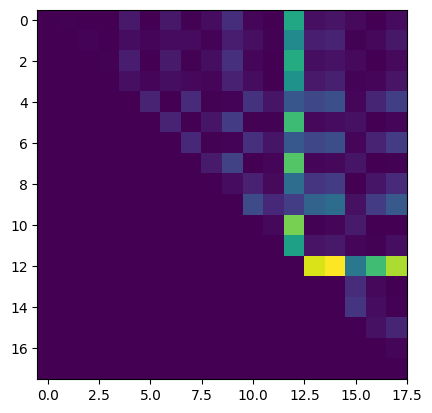

In [29]:
plt.imshow(res_arr, cmap="viridis")

In [117]:
x,y = np.meshgrid(comparisons, comparisons)

[['concept 0' 'concept 1' 'concept 2' 'concept 3' 'concept 4' 'concept 5'
  'concept 6' 'concept 7' 'concept 8' 'cluster 0' 'cluster 1' 'cluster 2'
  'cluster 3' 'cluster 4' 'cluster 5' 'cluster 6' 'cluster 7' 'cluster 8']
 ['concept 0' 'concept 1' 'concept 2' 'concept 3' 'concept 4' 'concept 5'
  'concept 6' 'concept 7' 'concept 8' 'cluster 0' 'cluster 1' 'cluster 2'
  'cluster 3' 'cluster 4' 'cluster 5' 'cluster 6' 'cluster 7' 'cluster 8']
 ['concept 0' 'concept 1' 'concept 2' 'concept 3' 'concept 4' 'concept 5'
  'concept 6' 'concept 7' 'concept 8' 'cluster 0' 'cluster 1' 'cluster 2'
  'cluster 3' 'cluster 4' 'cluster 5' 'cluster 6' 'cluster 7' 'cluster 8']
 ['concept 0' 'concept 1' 'concept 2' 'concept 3' 'concept 4' 'concept 5'
  'concept 6' 'concept 7' 'concept 8' 'cluster 0' 'cluster 1' 'cluster 2'
  'cluster 3' 'cluster 4' 'cluster 5' 'cluster 6' 'cluster 7' 'cluster 8']
 ['concept 0' 'concept 1' 'concept 2' 'concept 3' 'concept 4' 'concept 5'
  'concept 6' 'concept 7' 'concept

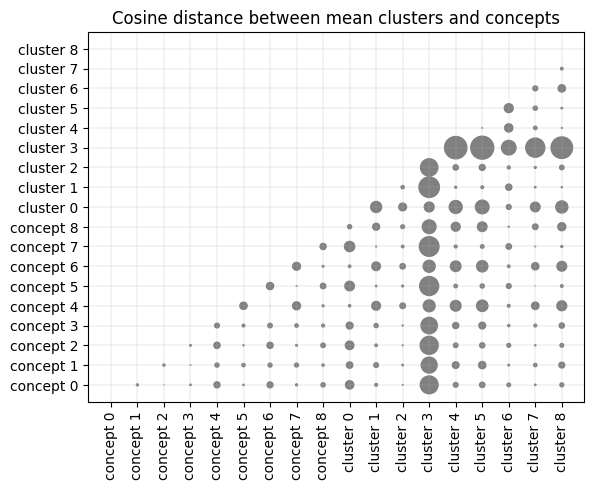

In [135]:
plt.figure()
plt.scatter(x=x.flatten(), y=y.flatten(), s=res_arr.flatten() * 3000, c="gray")
# plt.margins(.4)
plt.xticks(rotation=90)
    
plt.grid(linewidth=0.2)
plt.title("Cosine distance between mean clusters and concepts")
plt.show()

now do diff expression

In [141]:
res_arr = np.zeros((N,N))
print(res_arr.shape)
for i in range(N):
    for j in range(N):
        key0, val0 = comparisons[i].split(" ")
        key1, val1 = comparisons[j].split(" ")
        val0, val1 = int(val0), int(val1)
        if key0 == key1 and val0 == val1:
            res_arr[i,j] = 0
        if (key0, val0, key1, val1) in res_dict_diffexp.keys():
            res = res_dict_diffexp[(key0, val0, key1, val1)]
            res_arr[i,j] = res[2]

(18, 18)


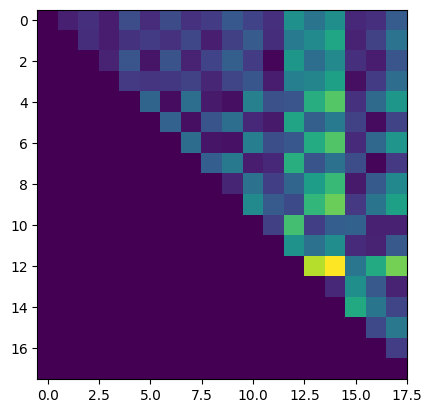

In [142]:
plt.imshow(res_arr, cmap="viridis")

In [143]:
x,y = np.meshgrid(comparisons, comparisons)

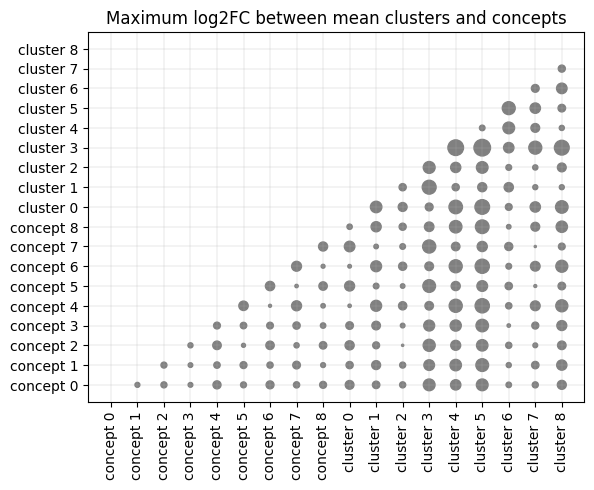

In [152]:
plt.figure()
plt.scatter(x=x.flatten(), y=y.flatten(), s=res_arr.flatten() * 30, c="gray")
# plt.margins(.4)
plt.xticks(rotation=90)
    
plt.grid(linewidth=0.2)
plt.title("Maximum log2FC between mean clusters and concepts")
plt.show()

In [154]:
de_points = list(res_dict_diffexp.values())
top_ids = [el[0] for el in de_points]
top_ids = list(set(top_ids))
[all_feats[i] for i in top_ids]

## Now we repeat this form of analysis with salient cells

In [15]:
EPS = 1e-6
def diff_exp_stable(X0, X1):
    mu0 = X0.mean(axis=0)    
    mu1 = X1.mean(axis=0)
    fc = np.log2((mu1 + EPS) / (mu0 + EPS))
    pval = stats.ttest_ind(X1, X0)[1]
    pval_adj = pval * len(pval)
    pval_sig = pval_adj < 0.01
    res = [(i, fc[i], np.abs(fc[i]), pval_sig[i]) for i in range(len(fc)) if pval_sig[i] == True]
    res.sort(key=lambda x: x[2], reverse=True)
    if len(res) == 0:
        print("No significant differences found")
        return np.nan
    return res[0]

def cos_dist(X0, X1):
    mu0 = X0.mean(axis=0)    
    mu1 = X1.mean(axis=0)
    return distance.cosine(mu0, mu1)

In [16]:
def compute_differences_2conds(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b, df, mode="diff_exp"):
    if key0_a == "cluster":
        search_key0_a = "exp_cluster"
    else:
        search_key0_a = key0_a
    if key1 == "cluster":
        search_key1_a = "exp_cluster"
    else:
        search_key1_a = key1_a
    if key0_b == "cluster":
        search_key0_b = "exp_cluster"
    else:
        search_key0_b = key0_b
    if key1_b == "cluster":
        search_key1_b = "exp_cluster"
    else:
        search_key1_b = key1_b
    
    subset0 = filter_data_2conds(search_key0_a, val0_a, search_key0_b, val0_b, df)
    subset1 = filter_data_2conds(search_key1_a, val1_a, search_key1_b, val1_b, df)
    
    X0 = subset0.loc[:, "raw"]
    X0 = X0.apply(lambda x: parse_df_list(x))
    try:
        X0 = np.vstack(list(X0.values))
    except ValueError:
        if len(X0) == 0:
            print("no subset retrieved for X0")
            return np.nan
        else:
            print("unexpected error")
            return np.nan
    
    X1 = subset1.loc[:, "raw"]
    X1 = X1.apply(lambda x: parse_df_list(x))
    try:
        X1 = np.vstack(list(X1.values))
    except ValueError:
        if len(X1) == 0:
            print("no subset retrieved for X1")
            return np.nan
        else:
            print("unexpected error")
            return np.nan
    
    if mode == "diff_exp":
        res = diff_exp_stable(X0, X1)
    elif mode == "cos_dist":
        res = cos_dist(X0, X1)
    return res

In [17]:
def difference_runner_sal(df, mode="diff_exp"):
    res_dict = {}
    
    # same concept, change salience (9)
    for i in range(9):
        key0_a, key0_b = "concept", "salbin"
        val0_a, val0_b = i, "non-salient"
        key1_a, key1_b = "concept", "salbin"
        val1_a, val1_b = i, "salient"
        print(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)
        res = compute_differences_2conds(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b, df, mode=mode)
        res_dict[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)] = res
        
    # change concept, keep salient (36)
    visited = {}
    for i in range(9):
        for j in range(9):
            if i == j:
                continue
            if (i,j) in visited.keys():
                continue
            if (j,i) in visited.keys():
                continue
            visited[(i,j)] = 1
            visited[(j,i)] = 1
            key0_a, key0_b = "concept", "salbin"
            val0_a, val0_b = i, "salient"
            key1_a, key1_b = "concept", "salbin"
            val1_a, val1_b = j, "salient"
            print(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)
            res = compute_differences_2conds(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b, df, mode=mode)
            res_dict[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)] = res
            
    # change concept, keep non-salient (36)
    visited = {}
    for i in range(9):
        for j in range(9):
            if i == j:
                continue
            if (i,j) in visited.keys():
                continue
            if (j,i) in visited.keys():
                continue
            visited[(i,j)] = 1
            visited[(j,i)] = 1
            key0_a, key0_b = "concept", "salbin"
            val0_a, val0_b = i, "non-salient"
            key1_a, key1_b = "concept", "salbin"
            val1_a, val1_b = j, "non-salient"
            print(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)
            res = compute_differences_2conds(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b, df, mode=mode)
            res_dict[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)] = res
    
    # same cluster, change salience (9)
    for i in range(9):
        key0_a, key0_b = "cluster", "salbin"
        val0_a, val0_b = i, "non-salient"
        key1_a, key1_b = "cluster", "salbin"
        val1_a, val1_b = i, "salient"
        print(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)
        res = compute_differences_2conds(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b, df, mode=mode)
        res_dict[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)] = res
        
    # change cluster, keep salient (36)
    visited = {}
    for i in range(9):
        for j in range(9):
            if i == j:
                continue
            if (i,j) in visited.keys():
                continue
            if (j,i) in visited.keys():
                continue
            visited[(i,j)] = 1
            visited[(j,i)] = 1
            key0_a, key0_b = "cluster", "salbin"
            val0_a, val0_b = i, "salient"
            key1_a, key1_b = "cluster", "salbin"
            val1_a, val1_b = j, "salient"
            print(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)
            res = compute_differences_2conds(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b, df, mode=mode)
            res_dict[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)] = res
            
    # change cluster, keep non-salient (36)
    visited = {}
    for i in range(9):
        for j in range(9):
            if i == j:
                continue
            if (i,j) in visited.keys():
                continue
            if (j,i) in visited.keys():
                continue
            visited[(i,j)] = 1
            visited[(j,i)] = 1
            key0_a, key0_b = "cluster", "salbin"
            val0_a, val0_b = i, "non-salient"
            key1_a, key1_b = "cluster", "salbin"
            val1_a, val1_b = j, "non-salient"
            print(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)
            res = compute_differences_2conds(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b, df, mode=mode)
            res_dict[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)] = res
            
    return res_dict
    

In [18]:
# res_dict_diffexp_sal = difference_runner_sal(dfGs_all, mode="diff_exp")

In [19]:
# res_dict_diffexp_sal.keys()

In [20]:
res_save_path = "/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/top_model_results/res_dict_de_sal.obj"
# serialize(res_dict_diffexp_sal, res_save_path)

In [21]:
res_dict_diffexp_sal = deserialize(res_save_path)

In [22]:
comparisons = []
for el in ["salient", "non-salient"]:
    for i in range(9):
        comparisons.append(el + " " + str(i))

In [23]:
len(res_dict_diffexp_sal.keys())

162

In [24]:
res_dict_diffexp_sal.values()

dict_values([(29, -1.4266607533195, 1.4266607533195, True), (29, 1.369039640854876, 1.369039640854876, True), (6, 0.1297129167451105, 0.1297129167451105, True), (29, -2.143729957412912, 2.143729957412912, True), (29, 2.9585044327071213, 2.9585044327071213, True), (29, 2.015102222818497, 2.015102222818497, True), (21, 0.6105247130080537, 0.6105247130080537, True), (17, -0.13826891751837878, 0.13826891751837878, True), (29, 2.1992777650382087, 2.1992777650382087, True), (29, 1.092078954569918, 1.092078954569918, True), (21, 0.6462059070237561, 0.6462059070237561, True), (29, -2.2158028079341534, 2.2158028079341534, True), (29, 1.9796020703660282, 1.9796020703660282, True), (29, 2.557242711389225, 2.557242711389225, True), (29, -0.3997920454128874, 0.3997920454128874, True), (21, 0.6623426456409666, 0.6623426456409666, True), (29, 1.5253556662365042, 1.5253556662365042, True), (21, 0.7970456043329447, 0.7970456043329447, True), (29, -2.0090670082194064, 2.0090670082194064, True), (29, 2.1

In [25]:
N = len(comparisons)
res_arr = np.zeros((N,N))
print(res_arr.shape)
for i in range(N):
    for j in range(N):
        key0_a, key0_b = "concept", "salbin"
        val0_b, val0_a = comparisons[i].split(" ")
        key1_a, key1_b = "concept", "salbin"
        val1_b, val1_a = comparisons[j].split(" ")
        val0_a, val1_a = int(val0_a), int(val1_a)
        
        if key0_a == key1_a and val0_a == val1_a:
            res_arr[i,j] = 0
        if key0_b == key1_b and val0_b == val1_b:
            res_arr[i,j] = 0
        if (key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b) in res_dict_diffexp_sal.keys():
            res = res_dict_diffexp_sal[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)]
            if (res is not np.nan) and (type(res) == tuple):
                print(res)
                res_arr[i,j] = res[2]
            else:
                print("NaN reached")

(18, 18)
(29, 1.092078954569918, 1.092078954569918, True)
(21, 0.6462059070237561, 0.6462059070237561, True)
(29, -2.2158028079341534, 2.2158028079341534, True)
(29, 1.9796020703660282, 1.9796020703660282, True)
(29, 2.557242711389225, 2.557242711389225, True)
(29, -0.3997920454128874, 0.3997920454128874, True)
(21, 0.6623426456409666, 0.6623426456409666, True)
(29, 1.5253556662365042, 1.5253556662365042, True)
(21, 0.7970456043329447, 0.7970456043329447, True)
(29, -2.0090670082194064, 2.0090670082194064, True)
(29, 2.1863378700807754, 2.1863378700807754, True)
(29, 2.763978511103972, 2.763978511103972, True)
(21, 0.5403763554743168, 0.5403763554743168, True)
(29, 0.864269810022469, 0.864269810022469, True)
(29, 1.7320914659512512, 1.7320914659512512, True)
(29, -1.6505635893418382, 1.6505635893418382, True)
(29, 2.5448412889583434, 2.5448412889583434, True)
(29, 3.1224819299815403, 3.1224819299815403, True)
NaN reached
(29, 1.222773228900037, 1.222773228900037, True)
(29, 2.090594884

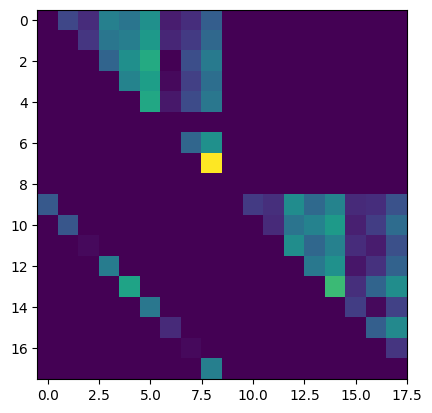

In [26]:
plt.imshow(res_arr, cmap="viridis")

In [27]:
x,y = np.meshgrid(comparisons, comparisons)

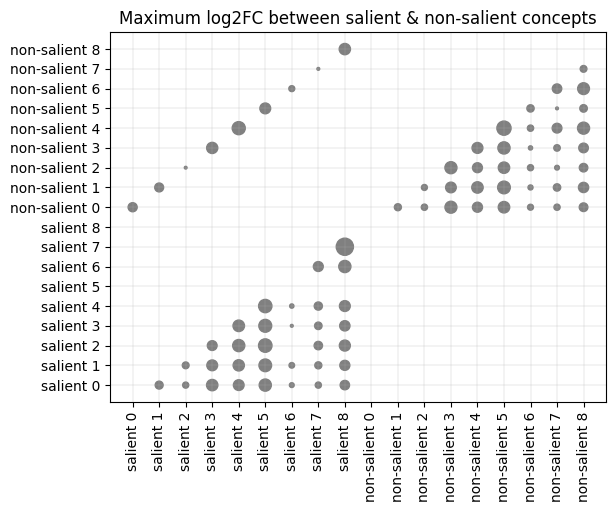

In [28]:
plt.figure()
plt.scatter(x=x.flatten(), y=y.flatten(), s=res_arr.flatten() * 30, c="gray")
# plt.margins(.4)
plt.xticks(rotation=90)
    
plt.grid(linewidth=0.2)
plt.title("Maximum log2FC between salient & non-salient concepts")
plt.show()

In [29]:
de_points = list(res_dict_diffexp_sal.values())
top_ids = [el[0] for el in de_points if type(el) == tuple]
top_ids = list(set(top_ids))
[all_feats[i] for i in top_ids]

NameError: name 'all_feats' is not defined

In [31]:
N = len(comparisons)
res_arr = np.zeros((N,N))
print(res_arr.shape)
for i in range(N):
    for j in range(N):
        key0_a, key0_b = "cluster", "salbin"
        val0_b, val0_a = comparisons[i].split(" ")
        key1_a, key1_b = "cluster", "salbin"
        val1_b, val1_a = comparisons[j].split(" ")
        val0_a, val1_a = int(val0_a), int(val1_a)
        
        if key0_a == key1_a and val0_a == val1_a:
            res_arr[i,j] = 0
        if key0_b == key1_b and val0_b == val1_b:
            res_arr[i,j] = 0
        if (key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b) in res_dict_diffexp_sal.keys():
            res = res_dict_diffexp_sal[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)]
            if (res is not np.nan) and (type(res) == tuple):
                res_arr[i,j] = res[2]
            else:
                print("NaN reached")

(18, 18)


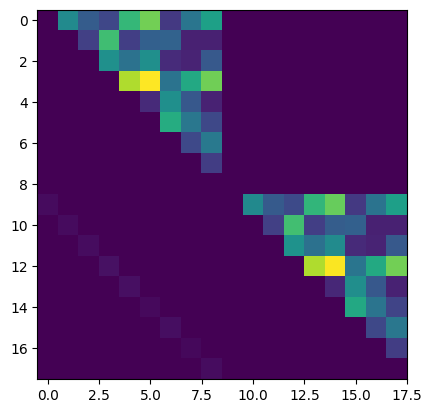

In [32]:
plt.imshow(res_arr, cmap="viridis")

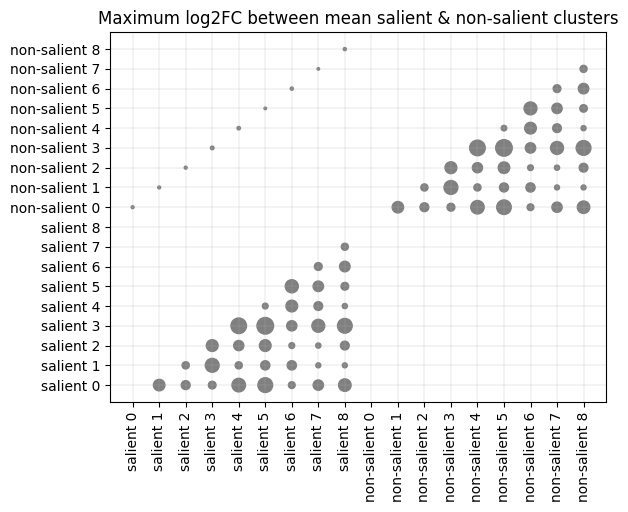

In [33]:
plt.figure()
plt.scatter(x=x.flatten(), y=y.flatten(), s=res_arr.flatten() * 30, c="gray")
# plt.margins(.4)
plt.xticks(rotation=90)
    
plt.grid(linewidth=0.2)
plt.title("Maximum log2FC between mean salient & non-salient clusters")
plt.show()

and now we do cosine

In [34]:
# res_dict_cosine_sal = difference_runner_sal(dfGs_all, mode="cos_dist")

In [35]:
res_save_path = "/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/top_model_results/res_dict_cd_sal.obj"
# serialize(res_dict_cosine_sal, res_save_path)

In [36]:
res_dict_cosine_sal = deserialize(res_save_path)

In [39]:
N = len(comparisons)
res_arr = np.zeros((N,N))
print(res_arr.shape)
for i in range(N):
    for j in range(N):
        key0_a, key0_b = "concept", "salbin"
        val0_b, val0_a = comparisons[i].split(" ")
        key1_a, key1_b = "concept", "salbin"
        val1_b, val1_a = comparisons[j].split(" ")
        val0_a, val1_a = int(val0_a), int(val1_a)
        
        if key0_a == key1_a and val0_a == val1_a:
            res_arr[i,j] = 0
        if key0_b == key1_b and val0_b == val1_b:
            res_arr[i,j] = 0
        if (key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b) in res_dict_cosine_sal.keys():
            res = res_dict_cosine_sal[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)]
            if (res is not np.nan):
                res_arr[i,j] = res
            else:
                print("NaN reached")

(18, 18)


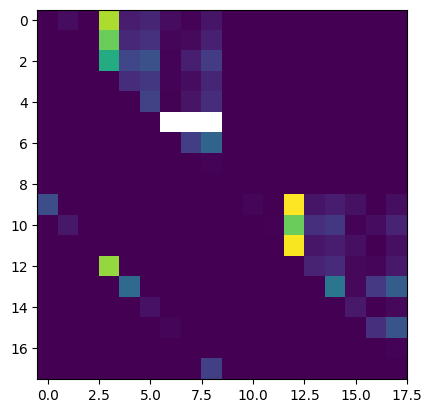

In [40]:
plt.imshow(res_arr, cmap="viridis")

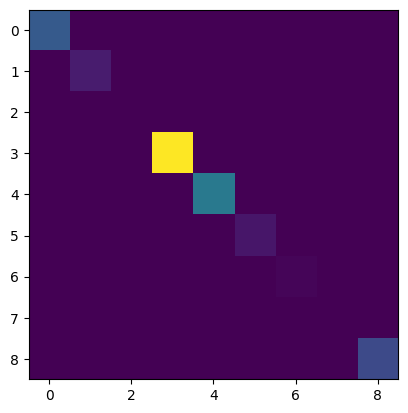

In [41]:
plt.imshow(res_arr[9:,0:9], cmap="viridis")

In [42]:
points_concepts = res_arr[9:, 0:9][res_arr[9:, 0:9].nonzero()]

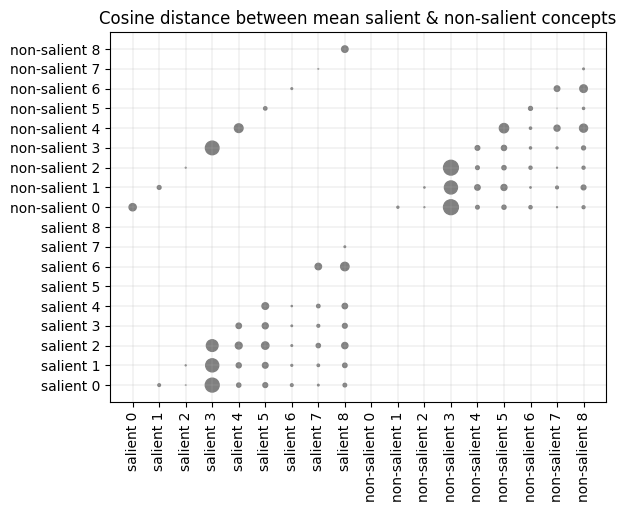

In [43]:
plt.figure()
plt.scatter(x=x.flatten(), y=y.flatten(), s=res_arr.flatten() * 2000, c="gray")
# plt.margins(.4)
plt.xticks(rotation=90)
    
plt.grid(linewidth=0.2)
plt.title("Cosine distance between mean salient & non-salient concepts")
plt.show()

In [44]:
N = len(comparisons)
res_arr = np.zeros((N,N))
print(res_arr.shape)
for i in range(N):
    for j in range(N):
        key0_a, key0_b = "cluster", "salbin"
        val0_b, val0_a = comparisons[i].split(" ")
        key1_a, key1_b = "cluster", "salbin"
        val1_b, val1_a = comparisons[j].split(" ")
        val0_a, val1_a = int(val0_a), int(val1_a)
        
        if key0_a == key1_a and val0_a == val1_a:
            res_arr[i,j] = 0
        if key0_b == key1_b and val0_b == val1_b:
            res_arr[i,j] = 0
        if (key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b) in res_dict_diffexp_sal.keys():
            res = res_dict_cosine_sal[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)]
            if (res is not np.nan):
                res_arr[i,j] = res
            else:
                print("NaN reached")

(18, 18)


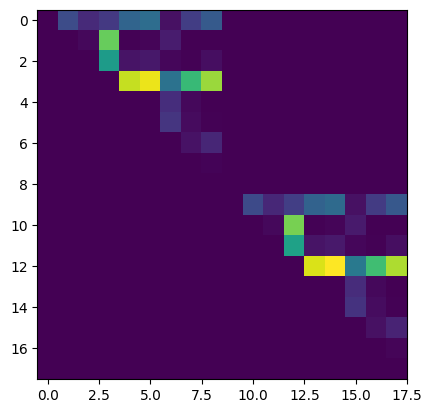

In [45]:
plt.imshow(res_arr, cmap="viridis")

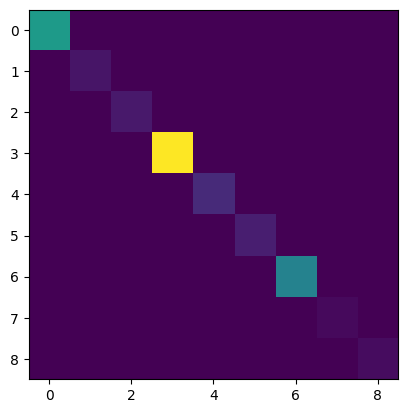

In [46]:
plt.imshow(res_arr[9:,0:9], cmap="viridis")

In [47]:
points_clusters = res_arr[9:, 0:9][res_arr[9:, 0:9].nonzero()]

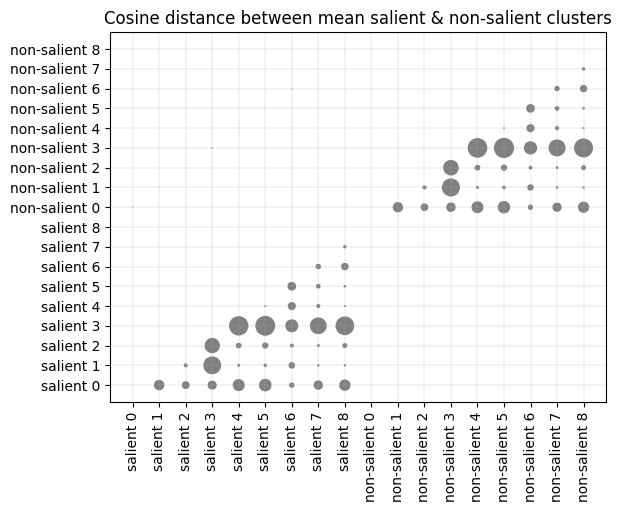

In [48]:
plt.figure()
plt.scatter(x=x.flatten(), y=y.flatten(), s=res_arr.flatten() * 2000, c="gray")
# plt.margins(.4)
plt.xticks(rotation=90)
    
plt.grid(linewidth=0.2)
plt.title("Cosine distance between mean salient & non-salient clusters")
plt.show()

### making this simpler by plotting the diagonals

In [49]:
import seaborn as sns

In [50]:
import seaborn as sns
sns.__version__

'0.13.2'

[array([2.22915284e-05, 2.31152699e-06, 2.84437947e-06, 4.08718779e-05,
       4.79830795e-06, 3.40243876e-06, 1.81191704e-05, 9.65684809e-07,
       1.38593812e-06]), array([1.34867228e-02, 3.65111920e-03, 1.42975100e-04, 4.78248174e-02,
       1.93557654e-02, 2.83443941e-03, 7.07900727e-04, 8.19481926e-05,
       1.08209708e-02])]


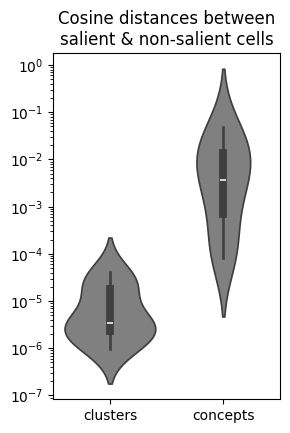

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 4), sharey=True)

data = [points_clusters, points_concepts]
print(data)
sns.violinplot(data=data, ax=ax, color= "gray", log_scale=True)
plt.tight_layout()

# parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=False)
# for pc in parts['bodies']:
#     pc.set_facecolor('gray')
#     pc.set_edgecolor('black')
# parts['cmedians'].set_colors("k")

ax.set_title('Cosine distances between\nsalient & non-salient cells')
labels = ["clusters","concepts"]
ax.set_xticks(np.arange(0, len(labels)), labels=labels)


# ax.set_yscale('log')
plt.show()

## finally, get ridgelines for salient cells

In [22]:
feat_subset = ['BETA_TUBULIN','CK5','CK7','P21','PANKERATIN','PHISTONEH3','AREA_CELL','MAJORAXISLENGTH']

In [47]:
def plot_ridgeline_sal(key_a, value_a, key_b, value_b, df, feat_names, feat2idx_dict=None):
    if key_a == "cluster":
        search_key_a = "exp_cluster"
    else:
        search_key_a = key_a
    if key_b == "cluster":
        search_key_b = "exp_cluster"
    else:
        search_key_b = key_b
    
    if len(feat_names) < 34 and feat2idx_dict is not None:
        idxs = [feat2idx_dict[feat] for feat in feat_names]
        
    X_all = df.loc[:, "raw"]
    X_all = X_all.apply(lambda x: parse_df_list(x))
    X_all = np.vstack(list(X_all.values))
    scaler = MinMaxScaler()
    scaler.fit(X_all)
    
    subset = filter_data_2conds(search_key_a, value_a, search_key_b, value_b, df)
    X = subset.loc[:, "raw"]
    X = X.apply(lambda x: parse_df_list(x))
    try:
        X = np.vstack(list(X.values))
    except ValueError:
        if len(X) == 0:
            print("no subset retrieved for X")
            return
        else:
            print("unexpected error")
            return
    X = scaler.transform(X)
    p = X.shape[1]
    
    plt.figure()
    if len(feat_names) < 34 and feat2idx_dict is not None:
        print("Note: only using a subset of features as requested...")
        X = X[:, idxs]
        p = X.shape[1]
        fig, ax = plt.subplots(figsize=(2, 4))
        w = 1.5
    else: 
        fig, ax = plt.subplots(figsize=(3, 12))
        w = 1
    
    ax.yaxis.grid(True, linestyle='-')        
    
    parts = ax.violinplot(X, positions=np.arange(p), widths=w, vert=False, showmeans=True, showmedians=False, showextrema=False, side="high")
    
    if key_a == "concept":
        c = joint_cmap(value_a)
    else:
        c = "brown"
        
    for pc in parts['bodies']:
        pc.set_facecolor(c)
        # pc.set_edgecolor('black')
        pc.set_alpha(0.8)
    parts['cmeans'].set_colors("k")
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title("Salient " + key_a + " " + str(value_a))
    #'Rescaled marker\ndistributions for ' +
    ax.set_yticks(np.arange(p), feat_names, rotation=0)
    ax.set_xlim(-0.05, 1.05)
    plt.show()
    
    return

In [48]:
# plot_ridgeline("concept", 0, dfGs_all, all_feats, feat2idx_dict=None, cond_count=2)
# plot_ridgeline_sal("concept", 0, "salbin", "salient", dfGs_all, all_feats, feat2idx_dict=None)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

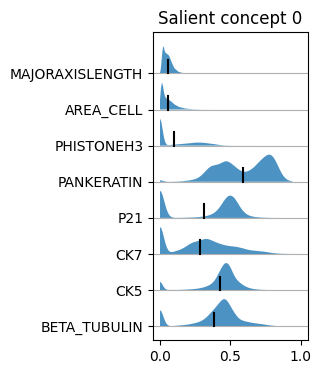

In [49]:
# plot_ridgeline("concept", 0, dfGs_all, feat_subset, feat2idx_dict, cond_count=2)
plot_ridgeline_sal("concept", 0, "salbin", "salient", dfGs_all, feat_subset, feat2idx_dict=feat2idx_dict)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

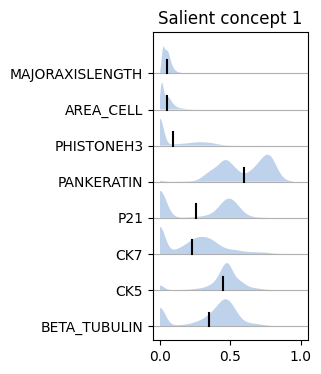

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

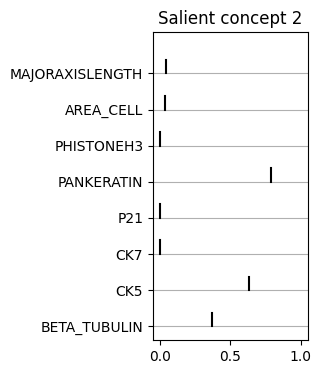

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

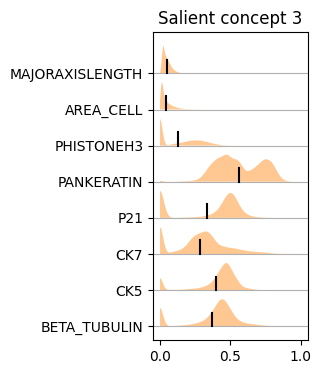

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

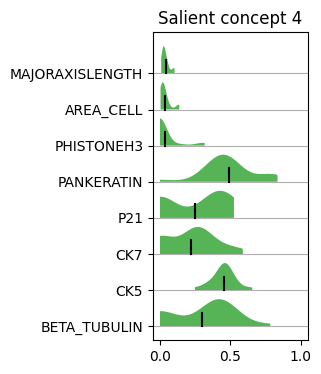

no subset retrieved for X
Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

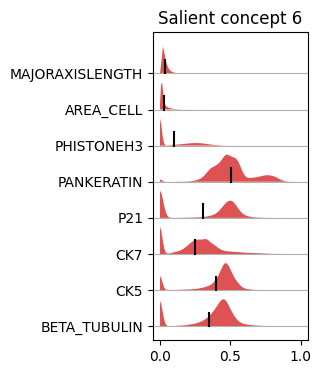

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

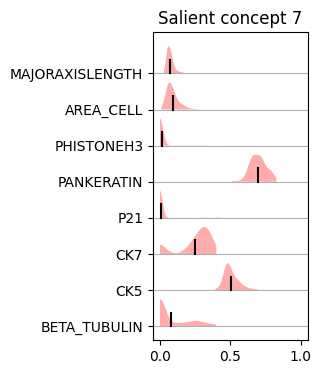

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

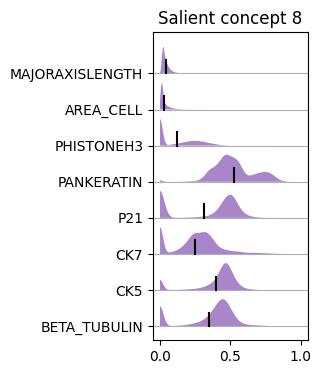

In [50]:
for i in range(1,9):
    plot_ridgeline_sal("concept", i, "salbin", "salient", dfGs_all, feat_subset, feat2idx_dict=feat2idx_dict)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

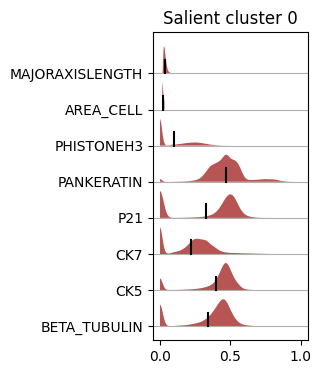

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

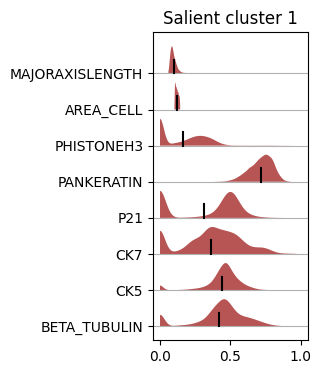

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

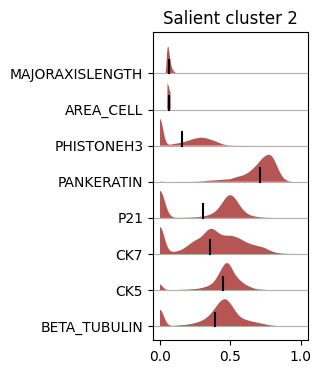

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

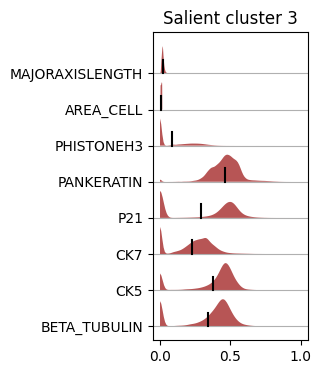

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

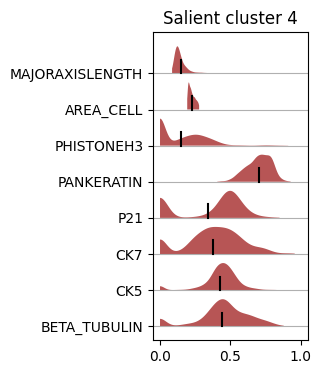

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

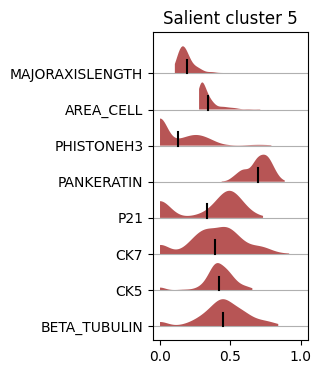

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

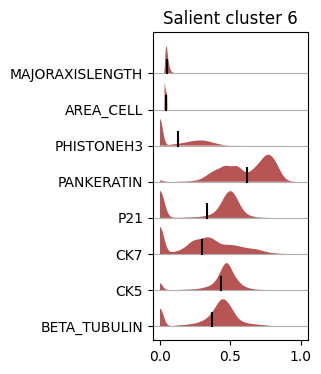

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

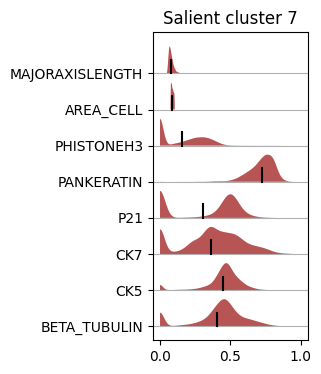

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

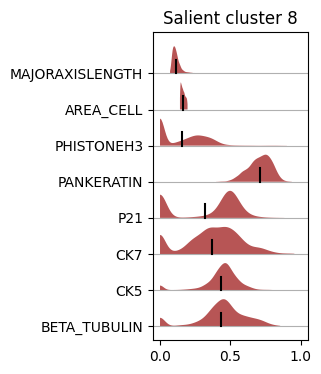

In [52]:
for i in range(9):
    plot_ridgeline_sal("cluster", i, "salbin", "salient", dfGs_all, feat_subset, feat2idx_dict=feat2idx_dict)